# Initialize the accelerator

In [8]:
import pynq
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

print([x.name for x in pynq.Device.devices])
print(pynq.Device.active_device.name)

['_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet']
['None', 'ZCU102']
None


In [5]:
#pynq.Device.active_device.name does not correctly resolve target platform automatically (for "ZCU102")
accel = models.mobilenetv1_w4a4_imagenet()
#accel = models.mobilenetv1_w4a4_imagenet("ZCU102")

#from finn_examples import driver
#accel = driver.FINNExampleOverlay("/home/xilinx/mobilenetv1-w4a4/bitfile/finn-accel.bit", 
                                  #"zynq-iodma", 
                                  #models._imagenet_top5inds_io_shape_dict,
                                  #batch_size=1, fclk_mhz=188.0, runtime_weight_dir="/home/xilinx/mobilenetv1-w4a4/driver/runtime_weights/")

Exception: Bitfile for model = mobilenetv1-w4a4 target platform = None not found. Looked in: ['/usr/local/lib/python3.6/dist-packages/finn_examples/bitfiles/None/mobilenetv1-w4a4.bit', '/usr/local/lib/python3.6/dist-packages/finn_examples/bitfiles/bitfiles.zip.d/None/mobilenetv1-w4a4.bit']

In [3]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 224, 224, 3) DataType.UINT8
Expected output shape and datatype: (1, 1, 1, 5) DataType.UINT16


# Load the ImageNet validation dataset

In [4]:
import numpy as np
from PIL import Image
from dataset_loading import FileQueue, ImgQueue
import os

#val_dir = os.environ["IMAGENET_VAL_PATH"]

val_dir = "/home/xilinx/dataset/ILSVRC2012_img_val/"
label_file ="/home/xilinx/dataset/ILSVRC2012_img_val/val.txt"

In [7]:
def img_resize(img, size):
    w, h = img.size
    if (w <= h and w == size) or (h <= w and h == size):
        return img
    if w < h:
        ow = size
        oh = int(size * h / w)
        return img.resize((ow, oh), Image.BILINEAR)
    else:
        oh = size
        ow = int(size * w / h)
        return img.resize((ow, oh), Image.BILINEAR)

def img_center_crop(img, size):
    crop_height, crop_width = (size, size)
    image_width, image_height = img.size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))

def pre_process(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    img = img_resize(img, 256)
    img = img_center_crop(img, 224)
    img = np.array(img, dtype=np.uint8)
    return img

# 2 ways to provide the data:
# without a label file: expect images in 1000 sorted subfolders
# with a label file: expect images directly in val directory
def setup_dataloader(val_path, label_file_path = None, batch_size=100, n_images = 50000):
    if label_file_path is None:
        val_folders = sorted(os.listdir(val_path))
        assert len(val_folders) == 1000, "Expected 1000 subfolders in ILSVRC2012 val"
        files = []
        labels = []
        for idx, folder in enumerate(val_folders):
            current_files = sorted(os.listdir(os.path.join(val_path, folder)))
            current_files = [os.path.join(folder, file) for file in current_files]
            files.extend(current_files)
            labels.extend([idx]*len(current_files))
        files = files[:n_images]
    else:
        files = ['ILSVRC2012_val_{:08d}.JPEG'.format(i) for i in range(1,n_images+1)]
        labels = np.loadtxt(label_file_path, dtype=int, usecols=1)

    file_queue = FileQueue()
    file_queue.load_epochs(list(zip(files,labels)), shuffle=False)
    img_queue = ImgQueue(maxsize=batch_size)
    img_queue.start_loaders(file_queue, num_threads=4, img_dir=val_path, transform=pre_process)
    return img_queue

# Classify a single image

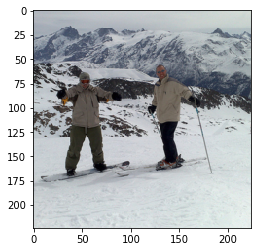

In [20]:
from matplotlib import pyplot as plt

img_queue = setup_dataloader(val_dir, label_file, 1, 1)

test_single_x, test_single_y = img_queue.get()

plt.imshow(test_single_x)
plt.show()

In [21]:
test_single_y

970

In [22]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [23]:
accel_out = accel.execute(accel_in)

In [24]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[[[795. 792. 970. 672. 537.]]]]


In [25]:
%%timeit
accel_out = accel.execute(accel_in)

100 loops, best of 3: 6.92 ms per loop


# Validate accuracy on entire ImageNet validation set

In [26]:
batch_size = 100
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )
obuf_packed = np.empty_like(accel.obuf_packed_device)

Accelerator buffer shapes are (100, 224, 224, 1, 3) for input, (100, 1, 1, 1, 10) for output


In [37]:
img_queue = setup_dataloader(val_dir, label_file, batch_size)

ok = 0
nok = 0
i = 0
while not img_queue.last_batch:
    imgs, lbls = img_queue.get_batch(batch_size, timeout=None)
    imgs = np.array(imgs)
    exp = np.array(lbls)
    
    ibuf_normal = imgs.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 1 : total OK 75 NOK 25
batch 2 : total OK 143 NOK 57
batch 3 : total OK 201 NOK 99
batch 4 : total OK 266 NOK 134
batch 5 : total OK 347 NOK 153
batch 6 : total OK 419 NOK 181
batch 7 : total OK 495 NOK 205
batch 8 : total OK 569 NOK 231
batch 9 : total OK 641 NOK 259
batch 10 : total OK 707 NOK 293
batch 11 : total OK 785 NOK 315
batch 12 : total OK 862 NOK 338
batch 13 : total OK 939 NOK 361
batch 14 : total OK 1006 NOK 394
batch 15 : total OK 1076 NOK 424
batch 16 : total OK 1140 NOK 460
batch 17 : total OK 1212 NOK 488
batch 18 : total OK 1281 NOK 519
batch 19 : total OK 1353 NOK 547
batch 20 : total OK 1418 NOK 582
batch 21 : total OK 1497 NOK 603
batch 22 : total OK 1564 NOK 636
batch 23 : total OK 1633 NOK 667
batch 24 : total OK 1710 NOK 690
batch 25 : total OK 1785 NOK 715
batch 26 : total OK 1855 NOK 745
batch 27 : total OK 1927 NOK 773
batch 28 : total OK 1998 NOK 802


KeyboardInterrupt: 

In [28]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

Final top-1 accuracy: 70.406%


## More benchmarking

In [29]:
from finn_examples import models
from finn_examples import driver

accel = driver.FINNExampleOverlay("/home/xilinx/mobilenetv1-w4a4/bitfile/finn-accel.bit", 
                                  "zynq-iodma", 
                                  models._imagenet_top5inds_io_shape_dict,
                                  batch_size=100, fclk_mhz=188.0)

accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 69.16120511873386,
 'DRAM_out_bandwidth[Mb/s]': 0.0045945741070587435,
 'batch_size': 100,
 'copy_input_data_to_device[ms]': 0.013064861297607422,
 'copy_output_data_from_device[ms]': 8.893013000488281e-05,
 'fclk[mhz]': 187.498125,
 'fold_input[ms]': 4.982948303222656e-05,
 'pack_input[ms]': 7.009506225585938e-05,
 'runtime[ms]': 217.64802932739258,
 'throughput[images/s]': 459.45741070587434,
 'unfold_output[ms]': 3.0040740966796875e-05,
 'unpack_output[ms]': 0.05037665367126465}